<a href="https://colab.research.google.com/github/suhayb-h/Acute-Lymphoblastic-Leukemia-Classifier/blob/main/3_ResNet50V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction

The utilization of neural networks in medicine continues to evolve every year, much like medical research in general. This central ethos is a reflection of the overall purpose of medicine which is the continual striving to improve patient care. Within the context of using data science as a tool in medical diagnosis, testing different models and tweaking the hyperparameters allows for the improvement in accuracy and precision, amongst other statistical outcomes. Ultimately, even a 1% percent improvement in any metric can result in diagnosing ALL earlier. 

In the previous paper, a CNN was used to showcase how neural networks could be constructed. In reality, there are many more neural networks that are much more complex than a CNN, and such networks might result in improved performance. The CNN constructed in the previous paper was relatively simple, containing a total of 6 layers. In a paper by SOMEONE et. al, the performance of 9 different neural networks were compared to one another with regards to diagnosing pathological slides. One of these models was the RESNET V2 model. This models contains over 50 layers and can allow for additional layers. In this report, the cell images are going to be passed through a RESNET V2 model to compare it's performance with the CNN model in the second report of this capstone project.

###Creating the Model

Constructing neural networks was relatively similar amongst models. Much of the process of establishing the ResNetV2 was identical to the process for the CNN model in the second report. The initial steps were to import relevant libraries, import the dataset, scale the data, and finally split the data into a training set and a validation set. This split was done directly within the image data generator, just as it was in the sequential CNN model construction.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix

Just as the sequential CNN model, the images in this dataset are passed through an image generator where they are rescaled and permitted to be randomly rotated and flipped horizontally or vertically. Since the test dataset had 1867 images, the validation dataset was set to 17.5% of the training dataset, equating to 1865 images. Within the generators themselves, all images were forced to retain their color and were subsequently shuffled.

In [4]:
# Created training image data-generator.
train_datagen = \
ImageDataGenerator(rescale=1./255, 
                   #rotation_range = 180, 
                   #horizontal_flip = True, 
                   #vertical_flip = True, 
                   validation_split = 0.175)

# Specified where images should be loaded from as well as additional attributes:
train_generator = \
train_datagen.flow_from_directory(
    '/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/training_data', 
    target_size = (224, 224), 
    color_mode = 'rgb', 
    class_mode = 'categorical',
    shuffle = True, 
    subset = 'training')

validation_generator = \
train_datagen.flow_from_directory(
    '/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/training_data', 
    target_size = (224, 224), 
    color_mode = 'rgb', 
    class_mode = 'categorical',
    shuffle = True, 
    subset = 'validation')

Found 8796 images belonging to 2 classes.
Found 1865 images belonging to 2 classes.


###Instantiating the ResNet50V2 Model

As previously mentioned, the ResNetV2 model is substantially more complex than the CNN model. By extention, the model has several hyperparamaters that can be adjusted to affect the overall performance of the model. There were several distinct decisions that were made in the creation of the ResNetV2 model for this report:

*   Unlike the CNN in the second report, this model is capable of utilizing pre-established weights. Most data science projects choose to set the weight parameter to the default "Imagnet". However, for the same reasons as mentioned in the second report, no weights were used in the instantiation of this model. 
*   The ResNetV2 model allows for a fully connected layer that lies on top of the model. A fully connected layer is dense layer that is more deeply connected with the layer below it, when compared to a traditional dense layer. This layer was turned off simply because it goes against the purpose of this report. This ResNetv2 model was constructed to compare it's baseline performance to that of the CNN in the second report. To establish a baseline, the model should be simplified as much as possible, with the exclusion of as many extra layers as possible. 
*   The layers in the default ResNetV2 model were frozen, resulting in no training being possible on these layers. This decision was made to, again, serve the purpose of comparing the baseline performance of a ResNetV2 model to the performance of the CNN model created in the second report. The CNN model had 6 layers and thus the ResNetV2 model was constructed to emulate 6 layers. By disallowing the default 150+ layers to be trained, these layers effectively serve as one untrainable layer, and 5 new layers were added at the end of the model. These subsequent 5 layers are capable of training, which means any improvement in performance of this model will be a direct result of these 5 additional layers, and not the default ResNetV2 layers.
*   The classification by which loss was measured in this model was identical to the CNN model, being a "Binary Cross-Entropy". Since this model is a binary classifier, setting the loss classifier to binary is the most appropriate decision, just as it was for the CNN model.



In [5]:
# Specify how the machine names classes:
class_names = validation_generator.class_indices
class_names

{'all': 0, 'hem': 1}

In [6]:
# Weight of 2.15 is applied to 'hem' cells
weights = {0: 1,
           1: 2.15}

In [7]:
resnet_model = ResNet50V2(weights = 'imagenet',
                   include_top = True,
                   input_shape = (224, 224, 3))
resnet_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [8]:
for layer in resnet_model.layers:
    layer.trainable = True

5 additional layers were added to this model:


*   A flattened layer was added...
*   Three dense layers were added and were specifically designated to contian regularizer parameters. The primary purpose of the kernel and activity regularizers was to reduce overfitting. Bias regularizers were also an option, but were ultimately decided against, since.... Two regularizers were available, L1 and L2, with the option to utilize both regularizers in conjuntion for each parameter. Ultimately, L2 was chosen as the sole regularizer since it specifically serves the function of reducing overfitting.
*   The final output layer of this model was set to a sigmoid activating dense layer with two outputs. This final output layer serves to provide a binary classification system between two final results, those being cancerous and non-cancerous. 



In [9]:
# Added a flatten layer
x0 = Flatten()(resnet_model.output)

In [10]:
# Added Dense Layers
#x1 = Dense(128, activation="relu", kernel_regularizer = regularizers.L2(0.01), activity_regularizer = regularizers.L2(0.01))(x0)
#x2 = Dense(64, activation="relu", kernel_regularizer = regularizers.L2(0.01), activity_regularizer = regularizers.L2(0.01))(x1)
#x3 = Dense(32, activation="relu", kernel_regularizer = regularizers.L2(0.01), activity_regularizer = regularizers.L2(0.01))(x2)
output = Dense(2, activation="sigmoid")(x0) # <-- The final output layer of the model is set to a sigmoidal activator with 2 nodes, signifying 2 binary outcomes

In [11]:
model = Model(inputs = resnet_model.input, 
              outputs = output)

In [12]:
model.compile(optimizer = 'SGD',
              loss = 'binary_crossentropy',
              metrics = ['categorical_accuracy'])

In [13]:
# Training stopped early once there were no improvements in validation accuracy
early_stop = EarlyStopping(monitor = 'val_categorical_accuracy', 
                           patience = 10, 
                           verbose = 1)

model_2 = model.fit(train_generator,
          epochs = 50,
          validation_data = validation_generator,
          class_weight = weights,
          callbacks = [early_stop])

Epoch 1/50
275/275 [==============================] - 101s 331ms/step - loss: 0.9456 - categorical_accuracy: 0.6617 - val_loss: 0.6923 - val_categorical_accuracy: 0.4300
Epoch 2/50
275/275 [==============================] - 87s 318ms/step - loss: 0.9391 - categorical_accuracy: 0.7499 - val_loss: 0.6868 - val_categorical_accuracy: 0.6708
Epoch 3/50
275/275 [==============================] - 87s 317ms/step - loss: 0.9126 - categorical_accuracy: 0.7791 - val_loss: 0.6707 - val_categorical_accuracy: 0.7802
Epoch 4/50
275/275 [==============================] - 87s 317ms/step - loss: 0.8615 - categorical_accuracy: 0.8461 - val_loss: 0.6513 - val_categorical_accuracy: 0.7936
Epoch 5/50
275/275 [==============================] - 87s 316ms/step - loss: 0.8014 - categorical_accuracy: 0.8817 - val_loss: 0.6449 - val_categorical_accuracy: 0.7560
Epoch 6/50
275/275 [==============================] - 87s 318ms/step - loss: 0.7516 - categorical_accuracy: 0.8874 - val_loss: 0.5943 - val_categorical_ac

###Analysis of Model Performance

For the purposes of this preliminary report, an early stop was set in place for this model based on insufficient improvements in lowering validation loss. This was the same strategy used for the sequential CNN model in the second report. Based on the preliminary analysis of 16 epochs, this model seems to have a lot of room for parameter optimization. There is definite overfitting of the training data, as dilineated by the two graphs below. In typical workflows, the model would continuously be optimized in an iterative process. For the purposes of this preliminary report, analysis was continued as if this model had been completely optimized. Testing data analysis resulted in incredibly low accuracy values despite the model having trained well. To get a better understanding of how the model was being trained, the validation set will be used for final analysis in place of the test dataset. The test data will still be importated as it would in normal workflows. 

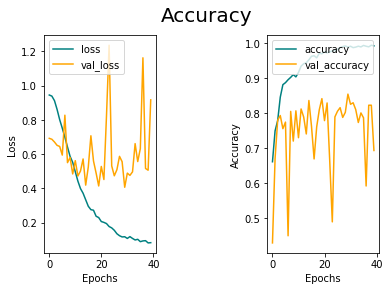

In [14]:
fig = plt.figure()

plt.subplot(1, 2, 1)
plt.plot(model_2.history['loss'], 
         color = 'teal', 
         label = 'loss')
plt.plot(model_2.history['val_loss'], 
         color = 'orange', 
         label = 'val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc = "upper left")
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(model_2.history['categorical_accuracy'], 
         color = 'teal', 
         label = 'accuracy')
plt.plot(model_2.history['val_categorical_accuracy'], 
         color = 'orange', 
         label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc = "upper left")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplots_adjust(wspace=1) 
plt.show()

The final phase of analysis was to assess the models performance on the testing data. Just as before, the testing data was imported via a dataframe image generator.

In [15]:
df_test = \
pd.read_csv(
    "/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv", 
    dtype = str)

# a new column called labels_ was created wherein 'all' patients are labelled 0 
df_test.loc[df_test['Patient_ID'].str.contains('all'), 'true_labels'] = '0'

# labels_ was also given a label 1 for any patients that were non-cancerous
df_test.loc[df_test['Patient_ID'].str.contains('hem'), 'true_labels'] = '1'

df_test

,Patient_ID,new_names,labels,true_labels
0,UID_57_29_1_all.bmp,1.bmp,1,0
1,UID_57_22_2_all.bmp,2.bmp,1,0
2,UID_57_31_3_all.bmp,3.bmp,1,0
3,UID_H49_35_1_hem.bmp,4.bmp,0,1
4,UID_58_6_13_all.bmp,5.bmp,1,0
...,...,...,...,...
1862,UID_54_33_1_all.bmp,1863.bmp,1,0
1863,UID_55_24_1_all.bmp,1864.bmp,1,0
1864,UID_H32_20_1_hem.bmp,1865.bmp,0,1
1865,UID_54_30_2_all.bmp,1866.bmp,1,0


In [23]:
# Apply the same rescaling factor as our other generators
test_datagen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range = 180, 
                                  horizontal_flip = True, 
                                  vertical_flip = True)
test_generator = \
test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = '/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data',
    target_size = (224, 224),
    batch_size = 100,
    x_col = 'new_names',
    y_col = 'true_labels',
    color_mode = 'rgb',
    class_mode = 'categorical')

X_test, y_test = test_generator.next()

Found 1867 validated image filenames belonging to 2 classes.


###Final analysis

This model showcased a test accuracy of 73.44%. While this model did not result in an accuracy score higher than the sequential model, there are a few reasons why this model can  still be considered a success. Despite the overall accuracy being lower, fewer normal lymphoblasts were misdiagnosed as ALL cells. Additionally, more normal lymphoblasts were correctly labelled when compared to the sequential CNN model.

However, this model suffered from the same issue as the Sequential CNN. Both models were extremely unlikely to predict that any cell was a normal lymphoblast. Considering the distribution of the data, where only 31.79% of all images were healthy lymphoblasts in the training dataset, this isn't surprising. However, the two models should have still predicted normal lymphoblasts 31% of the time, accounting for about 79 predictions. Instead, based on the confusion matrix, the model only predicted 38 healthy lymphoblasts. 

In [24]:
# Evaluate the model's performance on the test data
score = model.evaluate(X_test, y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

4/4 [==============================] - 0s 72ms/step - loss: 1.0084 - categorical_accuracy: 0.6700
Test loss: 1.008413553237915
Test accuracy: 0.6700000166893005


In [25]:
# Calculate the predictions
predict_probas = model.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

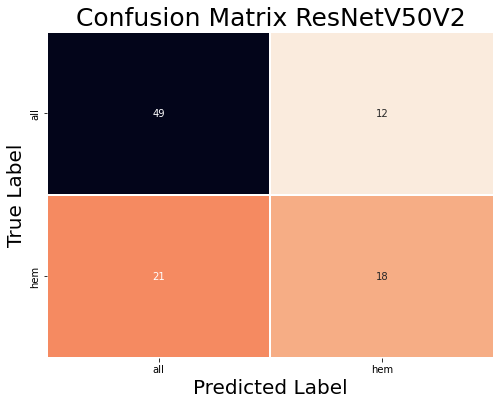

In [26]:
class_names = validation_generator.class_indices

y_test_labels = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_test_labels, y_predict)

plt.figure(figsize = (8,6))
sns.heatmap(conf_mat,
            annot=True,
            cbar=False,
            xticklabels = class_names,
            yticklabels = class_names,
            cmap = "rocket_r",
            linewidths = 1)
plt.title('Confusion Matrix ResNetV50V2', 
          size = 25, 
          y = 1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

###Conclusion and Future Advancements

This capstone project meant to serve as a case study to assess the efficacy of utilizing neural networks and machine learning to diagnose Acute Lymphoblastic Leukemia. Despite not establishing a useful model, it is worth reflecting on the limitations of the data that was available. 

The initial phase of this capstone project was an experience in understanding the limitations of machine learning. Despite having a small sample size, computational resources were consistently an issue when dealing with image data. Any classic modelling was impossible since it required dealing with images as numpy arrays. Such attempts caused even Google's CoLab GPUs to crash. Dealing with images as tensors proved to utilize GPU power much more efficiently and some classic machine learning models have started to gain development on tensorflow and pytorch, specifically logistic regression and decision forests. These models are still in their preliminary development phases with very little documentation available on hyperparameter optimization, but implementing these models might provide new useful insights. 

This was a relatively small dataset, with only 12528 images available to train and test on. Furthermore, there is a class imbalance of roughly 69% cancer cells to 31% healthy lymphoblasts in the training dataset. Both of these factors can negatively impact the establishment of an effective neural network model. Reducing the dataset to create a more even split might affect performance positively or negatively. Having less data can result in substantially worse performance, so for the purposes of this preliminary report all images were utilized.

Neural network optimization is a mundane and iterative process. For the sequential CNN, more layers could be added, layers can be removed and parameters can be continued to be tweaked, but until the model is trained there is no means of knowing what combination works best for the model. The initial exploratory data analysis in report 1 showcased a clear differentiation of cells based on size and eosin colour distribution, so adjusting the mathematical formulas of individual layers to better select for these two variables might result in a better performing model.

The ResNetV2 model has the most potential for improved performance. Independent testing in turning on the fully connected top dense layer and allowing the default layers to be trainable resulted in increased performance but significant overfitting. Adding more layers or tuning parameters within these layers might have allowed for these two features to be active while reducing overfitting. Furthermore, this specific model is called the ResNet50V2 because it has 50 default layers and is the second iteration of the model. A V3 does exist and might result in improved performance, while other ResNet models exist with thousands of layers. Above all else, one feature within this model holds the most potential for improved performance, that being the allowance for weight data. ImageNet was specifically decided against since these weights were established from the differentiation of everyday objects instead of minutia between extremely similar cells. A medical ImageNet does exist but is over 1000 terabytes in size. Being able to train any medical image classifier on this specific weight library might result in the highest possible performance. 